<a href="https://colab.research.google.com/github/adamzki99/nlp-zlatan/blob/feature%2Fall-MiniLM-L6-v2-implementation/nlp_zlatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia

/content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia


# all-MiniLM-L6-v2

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 

In [3]:
import json

with open('valid_random_split.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


In [9]:
import pandas as pd

data_extract = {
    "chosen_topic": [],
    "speaker_passage": [],
    "candidate_responses": []
}

for i, conversation in enumerate(data):

  for j, dialog in enumerate(conversation['dialog']):

    if "Apprentice" in dialog['speaker']:

      data_extract['chosen_topic'].append(conversation['chosen_topic'])
      data_extract['speaker_passage'].append(dialog['text'])
      data_extract['candidate_responses'].append(dialog['candidate_responses'][:20])

extact_df = pd.DataFrame(data_extract)

extact_df

,chosen_topic,speaker_passage,candidate_responses
0,Gardening,"I like Gardening, even when I've only been doi...","[No, I have two rescue cats. The French Bulldo..."
1,Gardening,That sounds great. I've always thought that I...,"[The meaning of the phrase ""ice cream"" varies ..."
2,Gardening,"Great, I love the idea of growing my own veget...",[Isn't that the truth!! have you ever tried an...
3,Gardening,"Wow, it sounds amazing, the Micro-pigs are so ...",[I like them and think they are a cool additio...
4,Gardening,"Great, I enjoyed our chat. Great luck with th...",[Definitely hire someone. I can write but defi...
...,...,...,...
4460,Guitar,The Master of Puppets is a must listen to if y...,[When non-humans have multiple births the grou...
4461,Divorce,That has got to be tough. My parents are still...,"[You can watch a Dalas Mavericks game!, Are th..."
4462,Divorce,I have heard that a divorce can take a while. ...,[I thin my dads is carbonfiber I guess now the...
4463,Divorce,Yea I forget about that when I think about div...,[Yes I've heard about them. When did they buil...


In [6]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [14]:
selected_sentences = []
selected_conversation_topics = []

for c, row in extact_df.sample(100).iterrows():
  
  selected_conversation_topics.append(row['chosen_topic'])

  for resp in row['candidate_responses']:
    pair = (row['speaker_passage'], resp)
    selected_sentences.append(pair)


#selected_sentences[::1]

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Move model to GPU
model.to(device)

cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

## Using mean-pooling

We are using mean-pooling to aggregate the sentence embeddings into a vector representation that aims to capture the meaning of the sentence. This is performed by averaging the embeddings dimensions.

By also applying the attention mask wich is provided with the model, we are able improve the **accuracy** of the averaging. This is becase the function wont be taking into acount the words that wont provide usefull information, e.g. stop-words.

In [57]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [58]:
def perform_embedding(documents:list, device, model):

  encoded_documents = tokenizer(documents, padding=True, truncation=True, return_tensors='pt')

  encoded_documents.to(device)
  with torch.no_grad():
      model_output_documents = model(**encoded_documents)

  # Perform pooling
  embedding = mean_pooling(model_output_documents, encoded_documents['attention_mask'])

  # Normalize embedding
  #embedding = F.normalize(model_output_message, p=2, dim=1)

  return embedding

In [59]:
sentence_embeddings = perform_embedding(documents = selected_sentences, device = device, model = model)

## Visualizing Cluster with Hypertools

In [60]:
%pip install hypertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Number of clusters: 87


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hypertools/plot/plot.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwargs[kwarg]=np.array(kwargs[kwarg])


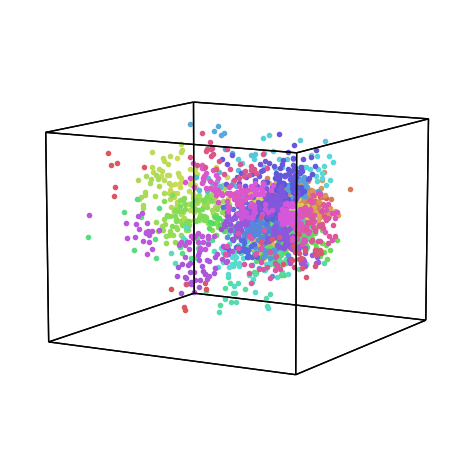

In [61]:
import hypertools as hyp

n_clusters = len(set(selected_conversation_topics))

print("Number of clusters:", n_clusters)

hyp.plot(sentence_embeddings.cpu().detach().numpy(), '.', n_clusters = n_clusters)

## Model usage

In [62]:
%pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import hnswlib

# Create the HNSW index
index = hnswlib.Index(space='l2', dim=sentence_embeddings.shape[1])
index.init_index(max_elements=len(sentence_embeddings), ef_construction=200, M=16)

# Add sentence embeddings to the index
index.add_items(sentence_embeddings.cpu().numpy())

In [64]:
# Get message
random_message = list(extact_df.sample(1).to_dict()['speaker_passage'].values())[0]
message = [random_message]

message

['I love to eat vegetarian']

In [65]:
query_embedding = perform_embedding(documents = message, device = device, model = model)

# Perform a similarity search
k = 10  # Number of closest neighbors to retrieve
labels, distances = index.knn_query(query_embedding.cpu(), k=k)
print(labels)

[[626 333 635 324 624 338 631 622 334 628]]


In [66]:
query_subset = []

for _, indexes in enumerate(labels):
  for i, ind in enumerate(indexes):
    print("Distance:", distances[0][i], "\t", selected_sentences[ind][1])
    query_subset.append(selected_sentences[ind])

Distance: 23.256224 	 What is your favorite meat?
Distance: 23.375504 	 You either love or you hate it, I've found
Distance: 26.232512 	 That's pretty great! Are you a vegan, then?
Distance: 27.468397 	 Now, that's what I am looking forward to! Where are you going first?
Distance: 28.473827 	 Hello dear, have ever draw anything?
Distance: 28.491953 	 I wonder also! Especially since you can get them in almost any restaurant, cafe, fast food outlet, grocery store, etc..
Distance: 28.864548 	 It sounds peaceful! Do you need to already be physically active to participate?
Distance: 29.087902 	 do you like the color blue? It is one of my favorite colors!
Distance: 29.18703 	 Well, they're severed hot and crisp here in USA. I love to slather them with ketchup, and sometimes fry sauce which is kinda like thousand island
Distance: 29.623068 	 Do you know about when they were created?


## Looking at the result

In [67]:
selected_sentences_embedding = perform_embedding(documents=query_subset, device=device, model=model)

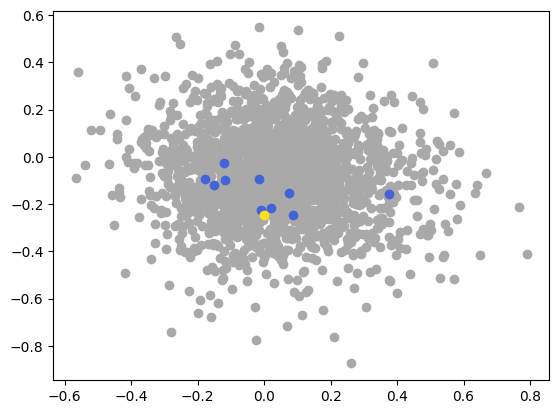

In [68]:
import matplotlib.pyplot as plt

plt.scatter(sentence_embeddings.cpu()[:,0] , sentence_embeddings.cpu()[:,1], c = '#a9a9a9')
plt.scatter(selected_sentences_embedding.cpu()[:,0] , selected_sentences_embedding.cpu()[:,1], c = '#4363d8')
plt.scatter(query_embedding.cpu()[:,0] , query_embedding.cpu()[:,1], color = '#ffe119')
plt.show()